# Introduction

A simple **Chat-with-Multi PDFs / Docs** app for **Retrieval-Augmented Generation (RAG)**.  
It allows you to ask questions about the contents of PDFs and DOC files, and the app will provide relevant responses.

![Chatbot Diagram](../src/images/graphWorkFlow.jpg)

This app is built using [**LangGraph**](https://www.langchain.com/langgraph) and [**LangChain**](https://www.langchain.com/).



In [1]:
# set Setting
import os 
import dotenv
from langchain.chat_models import init_chat_model
os.environ['GOOGLE_API_KEY'] = dotenv.get_key(key_to_get='GOOGLE_API_KEY', dotenv_path='.env')
llm = init_chat_model(model = 'gemini-2.5-flash' , model_provider='google-genai')

# A. Preprocess documents

- In this step we read files to get the full text and split them into small chunks and embed them to store in Vectore DataBase.


##### 1) Reading Files using PyPDF2 to extract text from pdf

In [2]:
from PyPDF2 import PdfReader

def get_content_pages(files:  list[str]) -> str:
    """Read PDF or TXT files and return their combined text"""
    ftext = ""
    for file_path in files:
        if file_path.lower().endswith(".pdf"):
            pdf_loader = PdfReader(file_path)
            for page in pdf_loader.pages:
                ftext += page.extract_text() or ""  
        else:
            with open(file_path, "r", encoding="utf-8") as f:
                ftext += f.read()
        ftext += "\n"
    return ftext

##### 2) Split Full text into small chunks

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter


def split_chunks(text : str , chunk_size :int = 600, chunk_overlap : int = 50) :
    """Split to small and overla chunks"""
    splitter= RecursiveCharacterTextSplitter("\n", chunk_size =chunk_size , 
                                         chunk_overlap =chunk_overlap)
    chunks = splitter.split_text(text)

    return chunks

##### 3) Initialize Vector Database

1. Generate embeddings from chunks using the **[MiniLM-L6-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)** model from SentenceTransformers.

2. Store the embeddings in a vector database using **Chroma** from LangChain.

In [4]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import InMemoryVectorStore


def create_vectorDB(chunks : list[str] ,
                    embedding_name  : str = "sentence-transformers/all-MiniLM-L6-v2" ) : 
    """Generate and store embedding of chunks into vector database"""
    embedding_model = HuggingFaceEmbeddings(model_name = embedding_name)
    vectordb = InMemoryVectorStore.from_texts(chunks , embedding_model)
    return vectordb

##### 4) concate components together


In [5]:
def ProcessDocuments(files:list[str]) :
    """concat all together""" 
    
    content = get_content_pages(files=files)
    chunks = split_chunks(content)
    vectorDB = create_vectorDB(chunks)
    return vectorDB , chunks

In [6]:
# testing functions
pdfs = [os.path.join('data' , x) for x in os.listdir("data")]  #pdf paths
vector_db ,chunks = ProcessDocuments(pdfs) 

C:\Users\szeya\AppData\Local\Temp\ipykernel_33700\2406254441.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name = embedding_name)
c:\Users\szeya\miniconda3\envs\chat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
query = "what is supervise learning?" 
similar_docs = vector_db.similarity_search(query, k=3)
for i, doc in enumerate(similar_docs):
    print("---" * 15, f"*{i+1}*", "---" * 15)
    print(doc.page_content)

--------------------------------------------- *1* ---------------------------------------------
So we call this supervised learning because we're supervising the algorithm or, in other 
words, we're giving the algorithm the, quote,  right answer for a number of houses. And 
then we want the algorithm to learn the a ssociation between the inputs and the outputs 
and to sort of give us more of the right answers, okay?  
It turns out this specific exam ple that I drew here is an example of something called a 
regression problem. And the term regression sort of refers to the fact that the variable 
you're trying to predict is a continuous value and price.
--------------------------------------------- *2* ---------------------------------------------
means. So on the upper left where the m ouse pointer is moving, this horizontal line 
actually shows the human steering direction, and this white bar, or this white area right 
here shows the steering direction chosen by the human driver, by mo

# B. Work-Flow-Graph

## 1) Define StateClass

In [8]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage

class MyState(TypedDict):
    messages: List[BaseMessage]
    detected_lang: str
    dialect: str

## 2) Generate a Retriever Tool using LangChain

- Use `create_retriever_tool` from **LangChain** to generate a retriever tool from the vector database.

##### 2.1) retriever_tool Function

In [9]:
from langchain.tools.retriever import create_retriever_tool 

retriver = vector_db.as_retriever()
retrivertool = create_retriever_tool(retriver , 
                                     "retriever_tool" ,
                                     "Search and return information about input context" )

print(retrivertool.invoke({"query": query}))


So we call this supervised learning because we're supervising the algorithm or, in other 
words, we're giving the algorithm the, quote,  right answer for a number of houses. And 
then we want the algorithm to learn the a ssociation between the inputs and the outputs 
and to sort of give us more of the right answers, okay?  
It turns out this specific exam ple that I drew here is an example of something called a 
regression problem. And the term regression sort of refers to the fact that the variable 
you're trying to predict is a continuous value and price.

means. So on the upper left where the m ouse pointer is moving, this horizontal line 
actually shows the human steering direction, and this white bar, or this white area right 
here shows the steering direction chosen by the human driver, by moving the steering 
wheel.  
The human is steering a little bit to the left here indicated  by the position of this white 
region. This second line here wh ere Mamos is pointing, the sec ond l

##### 2.2) retriever Agient

In [10]:
from langgraph.prebuilt import create_react_agent

RetriverAgent = create_react_agent(
    llm,
    tools=[retrivertool],
    name="RetriverAgent",
    prompt=(
        "You are a retriever agent.\n"
        "- Otherwise, always call the retriever_tool with the user query.\n"
        "- Return ONLY the page_content of the retrieved documents.\n"
        "- Do not summarize or rephrase.\n"
        "- Don't return repeated retrieved chunks.\n"
        "- If you didn't find similar text return 'I can't find it'."
    )
)


## 3) Detect Language and Dialect

##### 3.1) Detect Language using Prompt Template with structure ouput and Dialect if the query language is ar

#####  Detect Arabic dialect

- Using [IbrahimAmin/marbertv2-arabic-written-dialect-classifier](https://huggingface.co/IbrahimAmin/marbertv2-arabic-written-dialect-classifier)  
- The model predicts one of **5 Arabic dialects**:

| Code | Dialect | Region / Notes |
|------|---------|----------------|
| MAGHREB | Maghreb dialect | Northwest Africa (Morocco, Algeria, Tunisia, Libya, Mauritania) |
| LEV     | Levantine dialect | Lebanon, Syria, Jordan, Palestine |
| MSA     | Modern Standard Arabic | Formal Arabic (books, news, official use) |
| GLF     | Gulf dialect | Saudi Arabia, UAE, Kuwait, Bahrain, Qatar, Oman |
| EGY     | Egyptian dialect | Egypt |



In [54]:
from pydantic import Field, BaseModel
from langgraph.graph import MessagesState
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

class LanguageDetector(BaseModel):
    language: str = Field(
        description="Detected language of the question, represented in a two-character ISO 639-1 code."
    )


dialect_model_name = "IbrahimAmin/marbertv2-arabic-written-dialect-classifier"

dialect_pipeline = pipeline(
    "text-classification",
    model=AutoModelForSequenceClassification.from_pretrained(dialect_model_name),
    tokenizer=AutoTokenizer.from_pretrained(dialect_model_name),
)



def detecting_language(state: MyState):
    
   
    question = state['messages'][0].content
    
    detectionmodel = llm.with_structured_output(LanguageDetector)

    LANGUAGE_DETECTOR_TEMPLATE = "\n\n".join([
        "You are a language detector assessing to return the language of the question from a user.",
        "Here is the user question: {question}",
        "# Instructions:",
        "- Return only the two-character ISO 639-1 code for the language.",
        "- Base detection on the language of the question itself (its structure and wording), not on individual foreign words inside it.",
        "- Focus especially on the interrogative word (e.g., what, how, من, ماذا) and the main verb or auxiliary verb."
    ])


    detection_prompt = PromptTemplate(
        template=LANGUAGE_DETECTOR_TEMPLATE,
        input_variables=["question"]
    )


    prompt = detection_prompt.format(question=question)
    response: LanguageDetector = detectionmodel.invoke(prompt)


    # dialect
    dialect = None
    if response.language == "ar":
        preds = dialect_pipeline(question, top_k=None)
        if preds:
            best = max(preds, key=lambda x: x["score"])
            dialect = best["label"]
    
    
    return {
        "messages": state["messages"],
        "detected_lang": response.language,
        "dialect": dialect
    }



Device set to use cpu


In [12]:
#Test
from langchain_core.messages import HumanMessage
import time

examples = [
    ("Arabic Question", MessagesState(messages=[HumanMessage(content="ما هي أنواع Transformer؟")])),
    ("English Question", MessagesState(messages=[HumanMessage(content="What are the types of Transformer?")])),
    ("French Question", MessagesState(messages=[HumanMessage(content="Qu'est-ce qu'un transformateur?")])),
    ("Spanish Question", MessagesState(messages=[HumanMessage(content="¿Cuáles son los tipos de transformadores?")])),
    ("German Question", MessagesState(messages=[HumanMessage(content="Welche Arten von Transformatoren gibt es?")])) ,
]


for name, state in examples:
    result = detecting_language(state)
    print(f"{name}: {result['detected_lang'] ,result['dialect'] }")
    print("-" * 50)
    time.sleep(5)

Arabic Question: ('ar', 'MSA')
--------------------------------------------------
English Question: ('en', None)
--------------------------------------------------
French Question: ('fr', None)
--------------------------------------------------
Spanish Question: ('es', None)
--------------------------------------------------
German Question: ('de', None)
--------------------------------------------------


In [14]:
#Test
import time

examples = [
    ("EGY Example", MessagesState(messages=[HumanMessage(content="ازيك يصحبي قولي انواع l")])),
    ("LEV Example 2", MessagesState(messages=[HumanMessage(content="عامل اي يازلمي اليوم ممكن تقولي types of ML")])),
    ("GLF Example", MessagesState(messages=[HumanMessage(content="شلونك يا طويل العمر؟ ممكن تقول لي examples of ML")])),
    ("LEV Example", MessagesState(messages=[HumanMessage(content="كيفك يا زلمي؟ شو الأخبار؟ give me types of ML")])),
    ("MSA Example", MessagesState(messages=[HumanMessage(content="ما هي أنواع   ML techniques؟")]))
]



for name, state in examples:
    result = detecting_language(state)
    print(f"{name}: {result['detected_lang'] ,result['dialect'] }")
    print("-" * 50)
    time.sleep(5)

EGY Example: ('ar', 'EGY')
--------------------------------------------------
LEV Example 2: ('ar', 'LEV')
--------------------------------------------------
GLF Example: ('ar', 'GLF')
--------------------------------------------------
LEV Example: ('ar', 'LEV')
--------------------------------------------------
MSA Example: ('ar', 'MSA')
--------------------------------------------------


## 4) Translate Query to English

In [13]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState


def TranslateQuery(state :MyState):
    
    "Machine Translation to translate Queries to english text"
    
    user_messages = [m for m in state["messages"] if isinstance(m,HumanMessage)]
    question = state.get("translated_query", user_messages[-1].content)

    msg_prompt = f"""
                    You are a Machine Translation (MT) system.
                    Your task: translate the user question to English text.

                    Instructions:
                    1. Translate the question to English as accurately as possible.
                    2. Do not add explanations, comments, or extra content.
                    3. Do not attempt to clarify or modify the meaning.
                    4. Keep the original meaning exactly.

                    User question: "{question}"
                    """

    prompt_msg_template = PromptTemplate(
        template=msg_prompt,
        input_variables=['question']
    )

    resonong = llm.invoke([{'role': 'user', 'content': prompt_msg_template.format(question=question)}])

    return {'messages': [HumanMessage(content=resonong.content)]}


In [16]:
from langchain_core.messages import convert_to_messages

input_state = {
    "messages": convert_to_messages([
        {"role": "user", "content": "تقدر تفرق بين انواع transformers "}
    ])
}


response = TranslateQuery(input_state)
response["messages"][-1].pretty_print()

================================ Human Message =================================

Can you differentiate between types of transformers?


## 5) Grader
- Grander is a score computed from llm to determine whether the retrieved documents are relevant to the question.

In [14]:
from pydantic import BaseModel , Field
from typing import Literal
from langchain_core.messages import HumanMessage


class GraderDocument(BaseModel):
    """Grade documents using a binary score for relevance check."""
    binary_score : str = Field(description= "Relevance score: 'yes' if relevant, or 'no' if not relevant")


def GraderDocumentAgent(state: MyState)-> Literal['Chit-ChatAgent' ,'AnswerAgent'] :
    
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    question = state.get("translated_query", user_messages[-1].content)
    context = state['messages'][-1].content

      
    gradermodel = llm.with_structured_output(GraderDocument)
    
    GRADE_PROMPT = "\n\n".join([
    "You are a grader assessing relevance of a retrieved document to a user question.",
    "Here is the retrieved document: \n\n {context}",
    "Here is the user question: {question}",
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.",
    "If the question is an introductory or personal question (e.g., greetings like 'how are you', or self-introduction like 'I am X'), always grade it as 'yes'.",
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question." ])
    
    prompt = PromptTemplate(template= GRADE_PROMPT , input_variables=['question', 'context'])
    
    
    prompt_template = prompt.format(question = question , context = context)
    response =  gradermodel.invoke(
        [HumanMessage(content=prompt_template) ]
    )

    score = response.binary_score
    
    if score == 'yes' :
        return "AnswerAgent"
    else : 
        return 'Chit-ChatAgent'
    




In [18]:
# test
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does machine learning?",
            },
            
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retriever_tool",
                        "args": {"query": "Supervised learning, Unsupervised learning, Reinforcement learning."},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}


GraderDocumentAgent(input)

'Chit-ChatAgent'

In [19]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does machine learning?",
            },
            
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retriever_tool",
                        "args": {"query": "Supervised learning, Unsupervised learning, Reinforcement learning."},
                    }
                ],
            },
            {"role": "tool", 
             "content": """Machine learning is a field of artificial intelligence that focuses on building models that can learn from data and make predictions or decisions without being explicitly programmed. 
                            It is commonly used for tasks likelassification, regression, and pattern recognition. """, 
            "tool_call_id": "1"},
        ]
    )
}


GraderDocumentAgent(input)

'AnswerAgent'

## 6) Generate answer


In [15]:
def GenerateAnswer(state: MyState) :
    """Generate an answer."""

    GENERATE_PROMPT = "\n".join([
        "You are an assistant for question-answering tasks.",
        "Use the following pieces of retrieved context to answer the question.",
        "- you must first understand the question and the context to answer correctly.",
        "Answer as many questions as possible and make it a simple temporary one.",
        "- Generate english text only.",
        "- If the question is a greeting or introductory (like 'how are you', 'what's up', 'hello', 'hi', or self-introduction like 'I am X'), do not use the context. Instead, just greet back politely and say 'How can I help you?'.",
        "- If it is a normal question, add some information from the context in your answer to make it complete, not only from the context.",
        "Question: {question}\n",
        "Context: {context}"
    ])

    user_messages = [m for m in state["messages"] if isinstance(m,HumanMessage)]
    
    question = state.get("translated_query", user_messages[-1].content)
    context = state["messages"][-1].content

    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", 
                            "content": prompt}])
    
    return {"messages": [response]}

In [21]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What are the main types of machine learning?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_tool",
                        "args": {"query": "types of machine learning"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "Machine learning is commonly categorized into three main types: supervised learning, unsupervised learning, and reinforcement learning.",
                "tool_call_id": "1",
            },
        ]
    )
}

response = GenerateAnswer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The main types of machine learning are supervised learning, unsupervised learning, and reinforcement learning.


## 7) Chit-Chat Agent

In [16]:
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage

def chitChatAgent(state : MyState):
    user_messages= [m for m in state['messages'] if isinstance(m,HumanMessage)]
    question = state.get("translated_query", user_messages[-1].content)

    msg_prompt = f"""
        You are a Chit-Chat Assistant.
        Your task: reply politely when the context not related to  a user question so follow Instructions to senf a chit chat message.
        
        Instructions:
        1. Start by apologizing that you don't fully understand the question.
        2. Try to clarify by highlighting key words from the user's question.
        3. Use short, simple sentences to suggest that the user rephrase their question.
        5. shorts apologizing messages in first sentence only.
        6. write in english text only.
        7. don't require any language from user to write his question.
        8. ask only some question trying to understand user question
        

        User question: "{question}"
        """

    prompt_msg_template = PromptTemplate(
        template=msg_prompt,
        input_variables=['question']
    )

    resonong = llm.invoke([{'role': 'user', 'content': prompt_msg_template.format(question=question)}])

    return {'messages': [AIMessage(content=resonong.content)]}


In [23]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "where salaj play in zamilk",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_tool",
                        "args": {"query": "classification of machine learning"},
                    }
                ],
            },
            {"role": "tool", "content": "Supervised, Unsupervised, Reinforcement Learning", "tool_call_id": "1"},
        ]
    )
}

response = chitChatAgent(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I apologize, but I'm not entirely sure I understand your question. You mentioned "salaj" and "zamilk". Could you please rephrase it? Are you asking about a specific player or a team?


In [24]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "اين كنت وين ياولا",
            }
           
        ]
    )
}

response = chitChatAgent(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I apologize, but I don't fully understand your question. I'm having difficulty understanding the words you've used. Could you please try to rephrase it? What are you trying to ask about?


## 8)  Translate Agent

- Translate the reasoning into the same **language** and **dialect** of the question.


In [31]:
def TranslationReasoning(state: MyState):
    """Translate the reasoning into the same **language** and **dialect** of the question."""

    context = state["messages"][-1].content
    detected_lang = state.get("detected_lang")
    dialect = state.get("dialect")


    Translatetemplate = "\n".join([
        "You are a translation agent. Your ONLY job is to translate English text into the target language below.",
        "Never answer in Spanish, French, or any other language unless it exactly matches the detected language.",
        "you must know we shortcut the two-character ISO 639-1 code for the language like ar for arabic , en for english ",
        "",
        f"Target language: {detected_lang} ",
        f"Target dialect: {dialect or 'standard'}",
        "",
        "# Instructions:",
        "- If dialect is None, translate to the language only.",
        "- If the language is not English, keep important keywords in English.",
        "- Don't explain, don't rephrase, just translate.",
        "- If target language is Arabic, mimic the dialect if possible; otherwise use Modern Standard Arabic.",
        "",
        "Text to translate to targey language : ",
        "{context}"
    ])

    TranslatePrompt = PromptTemplate(
        template=Translatetemplate,
        input_variables=["context"],
    )

    prompt = TranslatePrompt.format(context=context)

    response = llm.invoke([
        {"role": "system", "content": "You are a strict translation agent. Respond ONLY with the translated text."},
        {"role": "user", "content": prompt}
    ])
    
    
    translated_text = response.content 
    return {"messages": [AIMessage(content=translated_text)]}

In [32]:

test_state = {
    "messages": [
        HumanMessage(content="Hello Islam! I'm doing well, thank you for asking! How can I help you?")  
    ],
    "detected_lang": "ar",    
    "dialect": "EGY"        
}

result = TranslationReasoning(test_state)

print("\n================ Translation Output ================\n")
for msg in result["messages"]:
    msg.pretty_print()



================ Translation Output ================

================================== Ai Message ==================================

إزيك يا إسلام! أنا كويس، شكراً إنك سألت! إزاي أقدر أساعدك؟


# Work Flow

In [48]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain.tools import StructuredTool

workflow = StateGraph(MyState)

workflow.add_node("DetectLangAgent", detecting_language)
workflow.add_node("Translate_Query", TranslateQuery)
workflow.add_node("RetriverAgent", RetriverAgent)
workflow.add_node("Chit-ChatAgent", chitChatAgent)
workflow.add_node("AnswerAgent", GenerateAnswer)
workflow.add_node("TranslationReasoning", TranslationReasoning)

workflow.add_edge(START, "DetectLangAgent")
workflow.add_edge("DetectLangAgent", "Translate_Query")
workflow.add_edge("Translate_Query", "RetriverAgent")

workflow.add_conditional_edges(
    "RetriverAgent",
    GraderDocumentAgent,
    {
        "AnswerAgent": "AnswerAgent",
        "Chit-ChatAgent": "Chit-ChatAgent",
    }
)

workflow.add_edge("AnswerAgent", "TranslationReasoning")
workflow.add_edge("Chit-ChatAgent", "TranslationReasoning")
workflow.add_edge("TranslationReasoning", END)

graph = workflow.compile(checkpointer=MemorySaver())



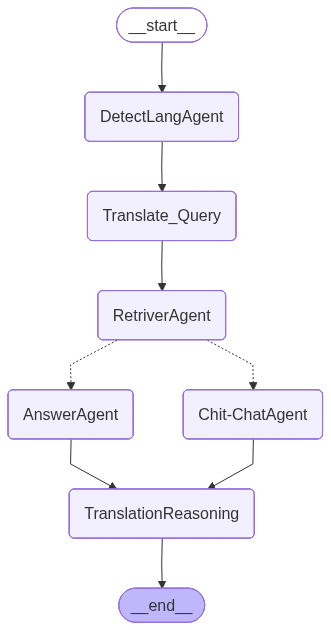

In [49]:
graph


In [50]:
from langchain_core.messages import HumanMessage

user_message = HumanMessage(content="اذيك ياصحبي انا اسلام عامل اي")

stream = graph.stream(
    {"messages": [user_message]},
    config ={"configurable": {"thread_id": "6"}},
    stream_mode="values"  
)

for chunk in stream:
    if "messages" in chunk:
        for msg in chunk["messages"]:
            msg.pretty_print()


================================ Human Message =================================

اذيك ياصحبي انا اسلام عامل اي
================================ Human Message =================================

اذيك ياصحبي انا اسلام عامل اي
================================== Ai Message ==================================
Name: DetectLangAgent

Detected language: ar
================================ Human Message =================================

How are you, my friend? I am Islam, how are you doing?
================================ Human Message =================================

How are you, my friend? I am Islam, how are you doing?
================================== Ai Message ==================================
Name: RetriverAgent
Tool Calls:
  retriever_tool (da4e8f24-3b5f-4963-b156-3f01c3fa4286)
 Call ID: da4e8f24-3b5f-4963-b156-3f01c3fa4286
  Args:
    query: How are you, my friend? I am Islam, how are you doing?
================================= Tool Message =================================
Name:

In [51]:
output = graph.invoke( {"messages": [
            HumanMessage(content=" يعني اي decoding") 
        ]} ,  config={"configurable": {"thread_id": "6"}})

output['messages'][-1].pretty_print()

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 21
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing

================================== Ai Message ==================================

فك التشفير يعني اختيار كلمة لتوليدها تاليًا بناءً على احتمالات نموذج لغوي كبير للكلمات المحتملة والسياق الحالي.


In [53]:
output

{'messages': [AIMessage(content='فك التشفير يعني اختيار كلمة لتوليدها تاليًا بناءً على احتمالات نموذج لغوي كبير للكلمات المحتملة والسياق الحالي.', additional_kwargs={}, response_metadata={})],
 'detected_lang': 'ar',
 'dialect': 'MSA'}

In [38]:
output = graph.invoke( {"messages": [
            HumanMessage(content="what is encoder decoder") 
        ]} ,  config={"configurable": {"thread_id": "6"}})

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

An encoder-decoder model is an architecture that typically consists of two main parts: an encoder and a decoder.

The **encoder** is used to provide a contextualized representation of input words or tokens, mapping a sequence of input embeddings to output embeddings of the same length, where the output vectors incorporate information from the entire input sequence. Bidirectional encoders, for example, generate these contextualized representations.

The **decoder** is a generative part that uses the contextualized representation provided by the encoder to produce running text by decoding or sampling. This architecture was developed for tasks like handwriting generation and machine translation.

In contrast, "encoder-only" models (like masked language models) produce an encoding for each input token but are generally not used for text generation, focusing instead on interpretative tasks. "Decoder-only" mode